# Lab 05 : ODE

## Objectives

In this lab we will solve a system of differential equations using `scipy.integrate.solve_ivp`.

Regardless of whether you consider baseball the great American pastime or a bunch of guys standing around watching grass grow, it is the case that there is a lot of interesting physics in baseball.
In this lab we will explore the amazing things a pitcher can do with a baseball.
In doing so we will use `scipy.integrate.solve_ivp` to solve the equation of motion of a spinning baseball.

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [135]:
import numpy as np
import scipy.integrate as integ
import matplotlib.pyplot as plt

## Baseball Motion

The physics of the motion of a baseball is an interesting study in its own right.
We will not undertake such a study and instead just use the results that came from the [Numerical Modeling of Baseball Pitching](http://people.kzoo.edu/barth/math280/articles/baseball.pdf).
In fact, we will consider exactly the cases discussed in this paper.
(Unfortunately this paper appears to not be available to anymore
It is not necessary to read, and there are other papers that solve similar problems, but this was a nice one.)
For our purposes we need the result that the force on a pitched baseball is
$$ \frac{1}{m} \vec F = - \left[ 1 + \frac{1.49}{1+\exp\left(\frac{v-v_d}{\Delta}\right)} \right] f |
\vec v| \vec v + B \vec\omega\times\vec v - g \hat z. $$
Here we have chose the $z$-axis to be vertical, $g$ is the usual gravitational constant, $\vec\omega$ is the spin of the baseball, and the constants are given by $v_d=35\,\mathrm{m/s}$, $\Delta=5\,\mathrm{m/s}$, $f=3.9\times 10^{-3}\,\mathrm{m^{-1}}$, and $B=4.1\times10^{-4}$.

### Units

A very important aspect of any problem we solve is to ensure that we keep units straight.
In the real world we have to deal with different sets of units used in different situations.
Failing to consistently use units or to correctly convert between different sets in different parts of a calculation has lead to [catastrophic results](http://spacemath.gsfc.nasa.gov/weekly/6Page53.pdf).
For an American sport and audience it sadly makes sense to specify speeds in miles per hour, distances in feet, and angular speed in revolutions per minute.
Care must be taken to ensure the calculations are done in a consistent set of units (it does not matter what set) and the results presented in the commonly used ones.

(*Note*: Actually, it really would make more sense to write every thing in terms of dimensionless variables and collect all the units details into a single place.
However, doing so does not alleviate the problem/danger of converting units.
We would still need to convert our constants and initial conditions from whatever units they are given in, to the dimensionless variables, then convert back for showing our results.
You are not required to do that here.)

### Initial Conditions

The main results of this lab will be plots of the trajectory of a pitched baseball.
The initial conditions for the four cases we will consider are given in the table below.
Note the units used in this table!

| **Pitch Name** | **Speed (mph)** | **Angle (deg)** | **Spin (rpm)** | **Orientation (deg)** |
| -------------- | :-------------: | :-------------: | :------------: | :-------------------: |
| Fastball | 95 | 1 | 1800 | 225 |
| Curveball | 85 | 1 | 1800 | 45 |
| Slider | 85 | 1 | 1800 | 0 |
| Screwball | 85 | 1 | 1800 | 135 |

### Function

To get started we need to write a function to pass to `solve_ivp` for solving our equations of motion.
We want to write a generic function that implements Newton's second law with the force given above.
Note that this is a three dimensional problem.
We will write a function in the form
`baseball_func(t, y, omegavec)`
as is appropriate for use with `solve_ivp`.

Here `t` is the current time step, `omegavec` is what we called $\vec\omega$ in the force above so it will be a three component array, and `y` is the array of variables representing what we are solving for in our equations of motion.
Decide an order in which to store the variables in `y` and **document your choice**.

A few things to keep in mind:
1. Choose a set of units for the calculation.
2. There are a few constants that appear in the force. You can just define them in `baseball_func` or include them as arguments with default values.
3. We have chosen the direction of the $z$-axis in our definition of the force (through the gravitational term, $g\hat z$) but are otherwise writing a generic function for a generic coordinate system. This is one benefit of writing equations in terms of vectors.
4. The force includes a term with the cross product. This can be calculated using `np.cross` if desired.

Write a function for the force on a baseball based on the discussion above.
You will use this function with `scipy.integrate.solve_ivp` to solve for the motion of a baseball.
**You must document this function.**
Provide a docstring and add any comments in the code such that any one looking at your function would immediately know how to use it!

In [ ]:
v_d = 35 # m/s 
delta = 5 # m/s
f = 3.9e-3 # m^-1
B = 4.1e-4 # unitless
g = 9.81 # m/s^2

def x(y):
    return y[0:3]

def v(y):
    return y[3:6]

def baseball_func(t, y, omegavec):
    dxdt = v(y)
    dvdt = -1 * (1 + 1.49/(1 + np.exp((v(y) - v_d)/delta)) * f * np.abs(v(y)) * v(y) + B * np.cross(omegavec, v(y)) + np.array([0, 0, -g]))

    return np.concatenate([dxdt, dvdt])

### Setting Initial Conditions

We now want to analyze the pitches with initial conditions given in the table above.
To begin, pick **one** of the pitches.
We will perfect our analysis for this one pitch and then apply it to all the others.

Though our function `baseball_func` is generic, the motions we are considering are a small subset of possible motions.
We will thus make some simplifying choices.

#### Coordinate System

We have already fixed the $z$-axis to point upward, that is, opposite the direction gravity acts.
We have freedom to choose the orientation of the $x$ and $y$ axes. We will choose the $x$-direction to be that in which the baseball is pitched, in other words, the direction from the pitcher's mound to home plate.
This means we can write the initial velocity as
$$ \vec v_0 = v_0 (\hat x \cos\theta + \hat z \sin\theta). $$
The column labeled "Angle" in the table above is what we are calling $\theta$ here.

#### Rotation Axis

In the coordinate system we have defined we will further choose the angular velocity, $\vec\omega$, to be in the $yz$-plane so that it can be written as
$$ \vec\omega = \omega (\hat y\sin\phi + \hat z\cos\phi).$$
The columns labeled "Spin" and "Orientation" in the table above are what we are calling $\omega$ and $\phi$, respectively.

#### Pitch Coordinates

The distance between the pitcher's mound and home plate on a baseball diamond is 60.5 feet.
(Strictly speaking, this is the distance between the edge of the rubber closest to home plate and to the back apex of the home plate.
This is not the actual distance the ball must travel as far as the batter is concerned, but is what we will use in our analysis.)
Further, we will assume the baseball is released directly above the edge of the rubber along the line between the pitchers mound and home plate.
In other words, we assume the baseball starts with $\vec r(0)=0$ in the coordinate system we have defined.
(Again this is not true.
The actual release point depends on the pitcher and the type of pitch thrown.)

### Analysis

Now that we know how to specify the initial conditions, we can solve for the motion of the baseball.
In doing so we must make sure you run for a long enough time so that the baseball at least goes a little past the back of home plate, as defined above.

We will use the solution to the equations of motion for the following purposes.
These are the required results for each of the pitches defined above.
1. Determine the time it takes for the baseball to reach the back of home plate. Also determine its speed, $|\vec v|$, at this time.
2. Produce a figure showing the horizontal, $y$, and vertical, $z$, displacements of the baseball as a function of its distance from the pitcher's mound, $x$. This figure should show the curves up to, and a little past, home plate. In the figure include a horizontal line at zero displacement and a vertical line at home plate. The figure you produce should contain the same curves as found in the paper referenced above. You should look at those figures to verify your calculations are correct. You should also look at them to see how to *not* produce figures. Okay, they are not *unreadable*, but they do leave much to be desired. You can produce much nicer looking figures.

How should we proceed?
The way I recommend is to start with one pitch, it does not matter which one, and do the steps by hand to get the desired results.
Once you understand these results, you can write a function that, given the initial conditions for a pitch, does these steps for you and produces the desired output.

When doing this **do not delete the cells below.**
Further **use the cells below for your final function definitions.**
This is a reminder that not messing up these cells makes grading significantly easier.
The answer cells contain metadata used during the grading process.
Without this metadata in place it I need to do much more work to clean up the mess!
This is true for all assignments done in notebooks.

Instead, you can do many things.
One is to create scratch cells, do work in them, and delete those after you have moved the relevant information into the function you will define below. 

Regardless of how you proceed, you want to analyze the pitches to determine the results requested above.
There are a few decisions you will have to make when doing this.
1. How do we determine how long to integrate the differential equation for? We can make an estimate, and that is sufficient. Alternatively, this is another opportunity to use the `events` keyword in `solve_ivp`.
2. How do we get an accurate estimate of the time it takes to reach the back of home plate and the speed at this time? Just using the `where` function is **not sufficient**. How can we do better? (There are a number of ways.)
3. How should we present the results? Here again we need to keep in mind units. We can work in whatever units we want, but the input and output should be in (American) readable units.

You should consider what you think would be the best way to organize the calculation.
To help you along, we will break up the problem into two steps. First, define a function that calculates the trajectory of the baseball.
This function should take as input the initial conditions in standard (American) units, convert the units if necessary, solve the differential equation for the trajectory of the baseball, convert the result back to American units (if necessary), and return arrays containing the position and velocity of the baseball along with an array for the times at which the position and velocity were evaluated.
Make sure you clearly document your function!

In [137]:
def solve_trajectory(speed, angle, spin, orientation):
    speed, angle, spin, orientation  = (
        0.44704*speed,
        np.deg2rad(angle),
        spin/60*2*np.pi,
        np.deg2rad(orientation)
    )

    y0 = np.array([0, 0, 0, speed * np.cos(angle), 0, speed * np.sin(angle)])
    omega_vec = spin * np.array([0, np.sin(orientation), np.cos(orientation)])

    return integ.solve_ivp(baseball_func, (0, 1000), y0, args=(omega_vec,), t_eval=np.linspace(0, 10, 1000))

Next define an analysis function that performs the requested analysis using the arrays from the trajectory function you defined above.
This should print the requested information and produce a plot using the input arrays.
Again clearly document your function and include in it a description of how you accurately find the time and speed.

*Note:* To produce clear output it makes sense to have a "name" associated with each pitch.
We should probably pass this information into our function in some way, ....

In [138]:
def analysis(title, speed, angle, spin, orientation):
    plt.figure()
    result = solve_trajectory(speed, angle, spin, orientation)

    y = result["y"]
    #print(y)
    y = y[:, ((y[0, :] > 0) & (y[0, :] < 60 / 3.28084))]
    plt.title(title)
    plt.plot(y[0, :] * 3.28084, y[2, :] * 3.28084, label="vertical displacement")
    plt.plot(y[0, :] * 3.28084, y[1, :] * 3.28084, label="horizontal displacement")
    plt.legend()
    

Finally, produce the results.
Apply your analysis function from above to each of the four pitches.

/tmp/ipykernel_1461478/3840784416.py:15: RuntimeWarning: overflow encountered in exp
  dvdt = -1 * (1 + 1.49/(1 + np.exp((v(y) - v_d)/delta)) * f * np.abs(v(y)) * v(y) + B * np.cross(omegavec, v(y)) + np.array([0, 0, -g]))


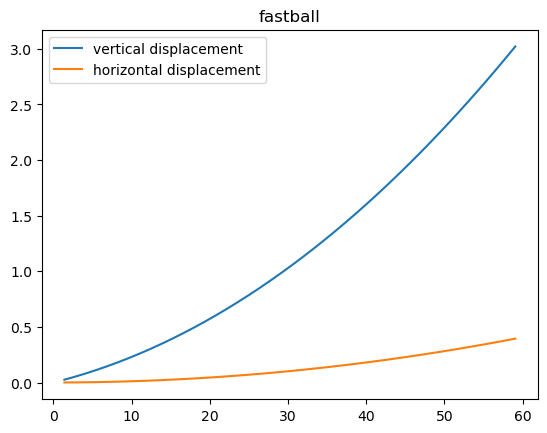

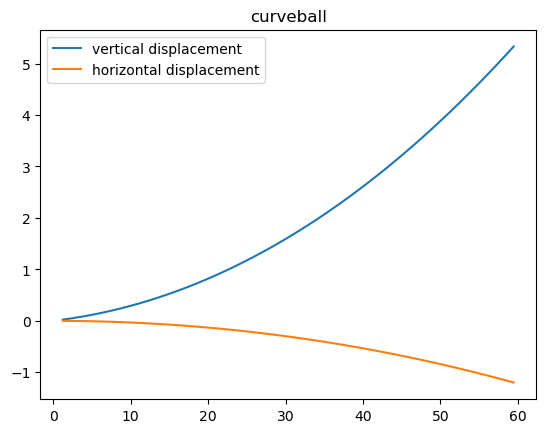

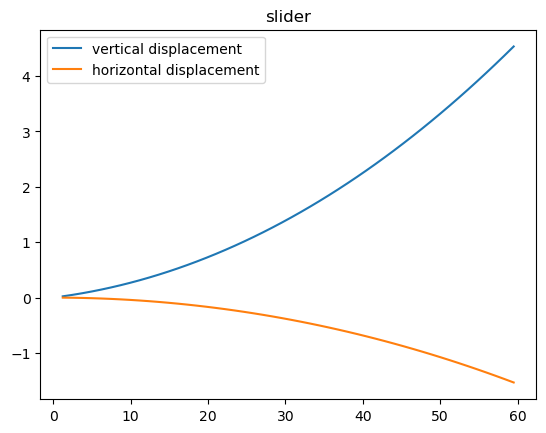

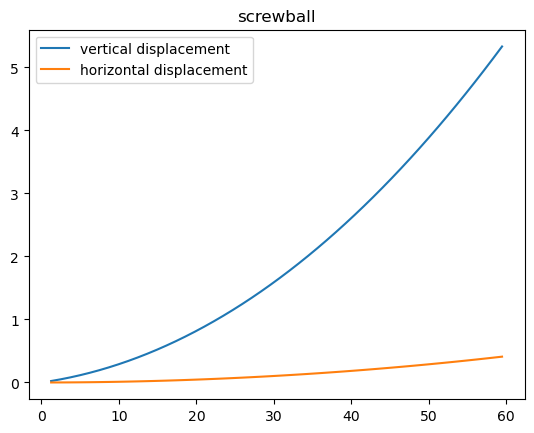

In [139]:
# speed, angle, spin, orientation
fastball  = ("fastball ".strip(), 95, 1, 1800, 225)
curveball = ("curveball".strip(), 85, 1, 1800, 45 )
slider    = ("slider   ".strip(), 85, 1, 1800, 0  )
screwball = ("screwball".strip(), 85, 1, 1800, 135)

[analysis(*args) for args in [
    fastball  ,
    curveball ,
    slider    ,
    screwball ,
]]
_ = ()

## Member Participation

See Lab00 for instructions on turning in labs.
We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who participated in this lab.
Again, see Lab00 for more details.
It is expected that you have read and understood those details.

YOUR ANSWER HERE